# pygamma-agreement Example Notebook

This notebook will show you some basic usage of the pygamma-agreement library.

First, let's load a csv file into a `Continuum` object and inspect
this object's properties. We'll use one of the short example files contained
in the `tests/data/` directory.

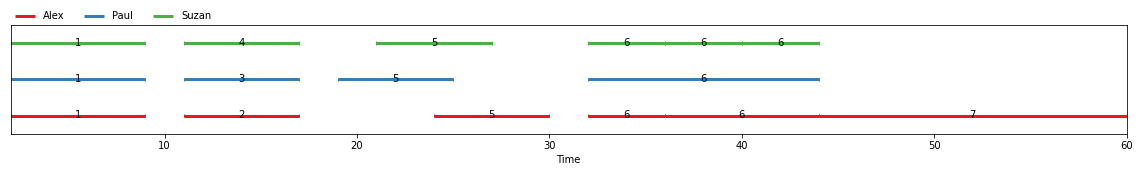

In [1]:
from pygamma_agreement import Continuum

continuum = Continuum.from_csv("../tests/data/AlexPaulSuzan.csv")
continuum

A continuum is made of _units_. A unit is a segment, optionally with some
text annotation, that has been annotated by some human or automatic annotator.
Let's have a look at these units:

In [2]:
for annotator, unit in continuum:
    print(annotator, " : ", unit)

Alex  :  Unit(segment=<Segment(2, 9)>, annotation='1')
Alex  :  Unit(segment=<Segment(11, 17)>, annotation='2')
Alex  :  Unit(segment=<Segment(24, 30)>, annotation='5')
Alex  :  Unit(segment=<Segment(32, 36)>, annotation='6')
Alex  :  Unit(segment=<Segment(36, 44)>, annotation='6')
Alex  :  Unit(segment=<Segment(44, 60)>, annotation='7')
Paul  :  Unit(segment=<Segment(2, 9)>, annotation='1')
Paul  :  Unit(segment=<Segment(11, 17)>, annotation='3')
Paul  :  Unit(segment=<Segment(19, 25)>, annotation='5')
Paul  :  Unit(segment=<Segment(32, 44)>, annotation='6')
Suzan  :  Unit(segment=<Segment(2, 9)>, annotation='1')
Suzan  :  Unit(segment=<Segment(11, 17)>, annotation='4')
Suzan  :  Unit(segment=<Segment(21, 27)>, annotation='5')
Suzan  :  Unit(segment=<Segment(32, 36)>, annotation='6')
Suzan  :  Unit(segment=<Segment(36, 40)>, annotation='6')
Suzan  :  Unit(segment=<Segment(40, 44)>, annotation='6')


We can also list some basic properties of this continuum instance

In [3]:
print(f"All annotators: {continuum.annotators}")
print(f"All categories: {continuum.categories}")
print(f"Unit count: {continuum.num_units}")
print(f"Average number of units per annotator: {continuum.avg_num_annotations_per_annotator}")
print(f"Average units lengths: {continuum.avg_length_unit}")

All annotators: SortedSet(['Alex', 'Paul', 'Suzan'])
All categories: SortedSet(['1', '2', '3', '4', '5', '6', '7'])
Unit count: 16
Average number of units per annotator: 5.333333333333333
Average units lengths: 6.8125


Enough playing around. Let's get down to business and actually do what you probably
came here for: computing the Gamma Inter-annotator agreement.
For that, we'll use a "combined categorical dissimilarity", which is, simply put,
a dissimilarity that measures both the temporal and categorical differences between
annotated units (for two different annotators from the continuum).

We'll also ask for 30 random continua to be sampled in the Gamma measure's
chance estimation.

In [4]:
from pygamma_agreement import CombinedCategoricalDissimilarity, CategoricalDissimilarity

cat_dissim = CategoricalDissimilarity(continuum.categories, delta_empty=1)
dissimilarity = CombinedCategoricalDissimilarity(cat_dissim=cat_dissim)

gamma_results = continuum.compute_gamma(dissimilarity,
                                        n_samples=30)
print(f"The gamma agreement is {gamma_results.gamma}")

The gamma agreement is 0.45602743577208105


We can also retrieve the best alignment for that continuum. This is the
list of per-annotator tuples of units that has the lowest _disorder_
(intuitively, when units from different annotators are grouped in tuples
in the best possible way):

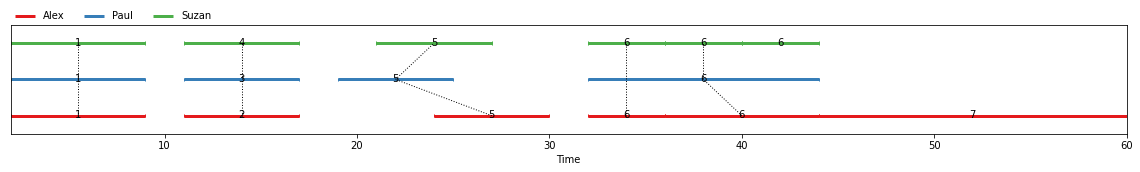

In [5]:
best_alignment = continuum.get_best_alignment(dissimilarity)
best_alignment

Up until now, we used a very simple and very short example file. All the
gamma computations should have been pretty fast. However, computing the gamma
measure can be quite costly for bigger files. Let's re-run the gamma measure
on some bigger files, as to give you a better sense of the time it can take
for larger files.

We'll also be using the `precision_level` parameter. The closer it is to 0,
the more precise our measure of the gamma will be (albeit more costly).

In [6]:
from time import time

files = [
    "../tests/data/AlexPaulSuzan.csv",
    "../tests/data/annotation_dalton.csv",
    "../tests/data/2by1000.csv",
]

for file in files:
    start_time = time()
    continuum = Continuum.from_csv(file)
    cat_dissim = CategoricalDissimilarity(continuum.categories, delta_empty=1)
    dissimilarity = CombinedCategoricalDissimilarity(alpha=3, beta=1, delta_empty=1.0, cat_dissim=cat_dissim)
    gamma_results = continuum.compute_gamma(dissimilarity,
                                            n_samples=30,
                                            precision_level=0.01)
    end_time = time()
    print(f"Took {end_time - start_time}s for {file}")
    print(f"Had to sample {gamma_results.n_samples} continuua")
    print(f"Gamma is {gamma_results.gamma} (with estimation range {gamma_results.approx_gamma_range})")

Took 0.6886322498321533s for ../tests/data/AlexPaulSuzan.csv
Had to sample 251 continuua
Gamma is 0.4576345488557345 (with estimation range (0.45215610995528743, 0.46300450381755887))
Took 1.8835525512695312s for ../tests/data/annotation_dalton.csv
Had to sample 663 continuua
Gamma is 0.5849015404131271 (with estimation range (0.5807086266799264, 0.5890114261516111))
Took 52.51757884025574s for ../tests/data/2by1000.csv
Had to sample 320 continuua
Gamma is 0.40411895266009046 (with estimation range (0.3980999521819095, 0.41001876500999057))
